In [11]:
%load_ext autoreload
%autoreload 2
from agent_configs import make_agent
from training import run_training, train_reps, train_or_load_condition
from eval_funcs import avg_stats, eval_holdout_stats, eval_total_cert_stats

def gauss(data, filters=[(0,100,1.0)]):
    from scipy.ndimage.filters import gaussian_filter1d
    for (st, en, sig) in filters:
        if(sig == 0): continue
        l = len(data) 
        en = max(en,l) if en != -1 else en
        if(l > st):
            data[st:en] = gaussian_filter1d(data[st:en],sigma=sig)
    return data

In [12]:
mc_conditions = {
    ("mc", "stand", False) : {"n_prob": 100, "reps" : 40},
    ("mc", "decision_tree", False) : {"n_prob": 100, "reps" : 40},
    ("mc", "random_forest", False) : {"n_prob": 100, "reps" : 40},
    ("mc", "xg_boost", False) : {"n_prob": 100, "reps" : 40},
    
    #("mc", "stand-relaxed", False) : {"n_prob": 100, "reps" : 6},
    #("mc", "stand", True) : {"n_prob": 100, "reps" : 1},
}

mc_conditions_active = {
    ("mc", "stand", False, True) : {"n_prob": 100, "reps" : 40},
    #("mc", "decision_tree", False, True) : {"n_prob": 100, "reps" : 20},
    ("mc", "random_forest", False, True) : {"n_prob": 100, "reps" : 40},
    ("mc", "xg_boost", False, True) : {"n_prob": 100, "reps" : 40},
    
    #("mc", "stand-relaxed", False) : {"n_prob": 100, "reps" : 6},
    #("mc", "stand", True) : {"n_prob": 100, "reps" : 1},
}

frac_conditions = {
    ("frac", "stand", False) : {"n_prob": 100, "reps" : 40},
    ("frac", "decision_tree", False) : {"n_prob": 100, "reps" : 40},
    ("frac", "random_forest", False) : {"n_prob": 100, "reps" : 40},
    ("frac", "xg_boost", False) : {"n_prob": 100, "reps" : 40},
}

frac_conditions_active = {
    ("frac", "stand", False, True) : {"n_prob": 100, "reps" : 40},
    #("frac", "decision_tree", False, True) : {"n_prob": 100, "reps" : 20},
    ("frac", "random_forest", False, True) : {"n_prob": 100, "reps" : 40},
    ("frac", "xg_boost", False, True) : {"n_prob": 100, "reps" : 40},
}

stat_cache = {}
def stats_by_cond(conditions, grp, stat_name, kind="avg"):
    out = {}
    for tup, kwargs in conditions.items():
        if(tup not in stat_cache):
            ret = train_or_load_condition(*tup, 
                    n_prob=kwargs.get("n_probs", 100), reps=kwargs.get("reps", 3))
            stat_cache[tup] = ret
            
        ret = stat_cache[tup]
        out[(tup[1], tup[2])] = ret[grp][stat_name][kind]
    return out

def stats_at_index_by_cond(conditions, grp, stat_name, index, kind="avg"):
    stats = stats_by_cond(conditions, grp, stat_name, kind)
    stats = {k:v[index] for k,v in stats.items()}
    return stats
    

def print_stat(name, val, prec=2):
    print(f"{name}: {val*100:.{prec}f}%")

def print_stats(conditions, grp, name, title=None, big_better=True, index=None):
    title = title if title else name
    if(index is None):
        d = stats_by_cond(conditions, grp, name)
    else:
        d = stats_at_index_by_cond(conditions, grp, name, index=index)
    print(f"{title}:")
    best_ind = np.argmax([d if big_better else -d for d in d.values()])
    for i, (cond, val) in enumerate(d.items()):
        when, proc = cond
        bold = best_ind == i
        pre = "\033[1m" if bold else ""
        post = "\033[0m" if bold else ""
        ps = "-proc" if proc else ""
        print(f"  {when}{ps}: {pre}{val*100:.2f}%{post}")

        


['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


/tmp/ipykernel_9239/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


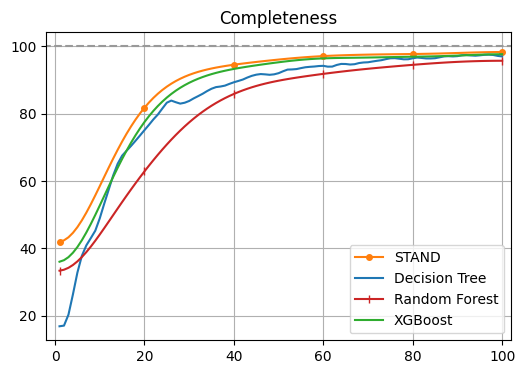

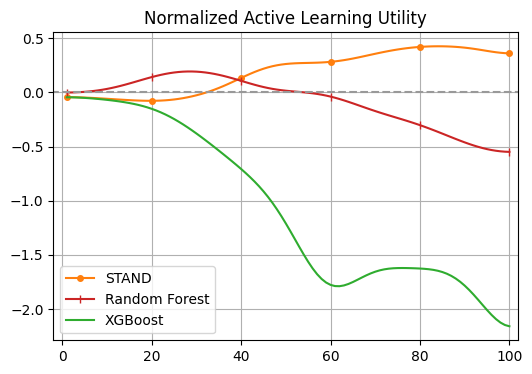

In [86]:
        
import matplotlib.pyplot as plt
import numpy as np

# Replace [2] lighten old green #2ca02c 
# Replace [3] darken old red #d62728
colors = ['#1f77b4', '#ff7f0e', '#2fac2f', '#cb2525', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

cond_colors = {
    "decision_tree" : colors[0],
    "random_forest" : colors[3],
    "xg_boost" : colors[2],
    "stand" : colors[1], # Orange
}

cond_labels = {
    "decision_tree" : "Decision Tree",
    "random_forest" : "Random Forest",
    "xg_boost" : "XGBoost",
    "stand" : "STAND",
}

cond_marker_props = {
    "stand" : {"marker" : ".", "markersize" : 8, "markevery" : [0,19,39,59,79, -1]},
    "random_forest" : {"marker" : "|", "markersize" : 6, "markevery" : [0,19,39,59,79, -1]},
}

def plot_stat(conditions, stat, grp=1, title=None, skip=[], y_lim=None, h_line=None, save_name=None):
    plt.figure(figsize=(6,4))
    
    title = title if title else stat
    for cond, curve in stats_by_cond(conditions, grp, stat).items():
        when, has_proc = cond 
        if(when in skip):
            continue
        plt.plot(np.arange(1,len(curve)+1), gauss(curve*100), color=cond_colors.get(when, "grey"), 
                 label=cond_labels.get(when, when), **cond_marker_props.get(when, {}))
    plt.grid()
    plt.title(title)
    plt.legend()    
    if(h_line is not None): plt.hlines(h_line, -10,110, linestyle='--', color="#999")
    if(y_lim): plt.ylim(*y_lim)
    plt.xlim(-2, 102)
    
    if(save_name): 
        plt.savefig(f"plots/{save_name}.png", bbox_inches='tight')
        plt.savefig(f"plots/{save_name}.eps", bbox_inches='tight', format='eps')
    plt.show()

def plot_diff(conditions, conds_active, stat, grp=1, title=None, h_line=None, save_name=None):
    plt.figure(figsize=(6,4))
    
    title = title if title else stat
    conds = {(a,b,c):conditions[(a,b,c)] for (a,b,c,d) in conds_active}
    stats = stats_by_cond(conds, grp, stat)
    stats_conds  = stats_by_cond(conds_active, grp, stat)
    for (c0, curve0), (c1, curve1) in zip(stats.items(), stats_conds.items()):
        when, has_proc = c0
        curve0 = gauss(curve0)
        curve1 = gauss(curve1)
        diff = ((curve1-curve0)/(1-curve0))
        plt.plot(np.arange(1,len(diff)+1), diff, color=cond_colors.get(when, "grey"), 
                 label=cond_labels.get(when, when), **cond_marker_props.get(when, {}))
    plt.grid()
    plt.title(title)
    plt.legend()
    if(h_line is not None): plt.hlines(h_line, -10,110, linestyle='--', color="#999")
    plt.xlim(-2, 102)

    if(save_name): 
        plt.savefig(f"plots/{save_name}.png", bbox_inches='tight')
        plt.savefig(f"plots/{save_name}.eps", bbox_inches='tight', format='eps')
    plt.show()
        
plot_stat(mc_conditions, "completeness", 0, "Completeness", h_line=100)    
#plot_stat(mc_conditions_active, "completeness", 0, "Completeness") 
plot_diff(mc_conditions, mc_conditions_active, "completeness", 0, "Normalized Active Learning Utility", h_line=0) 

## MC Addition Total Stats

In [83]:
print_stats(mc_conditions, 0, "completeness", "Completeness prob=20", True, index=19)
print_stats(mc_conditions, 0, "completeness", "Completeness prob=50", True, index=49)
print_stats(mc_conditions, 0, "completeness", "Completeness prob=100", True, index=99)
print()
print_stats(mc_conditions, 1, "total_prod_monot", "Total Productive Monotonicity")
print_stats(mc_conditions, 1, "total_error_reocc", "Total Error Reoccurance", False)
print_stats(mc_conditions, 1, "total_FN_reocc", "Total Comission Reoccurance", False)
print_stats(mc_conditions, 1, "total_FP_reocc", "Total Omission Reoccurance", False)
print()
print_stats(mc_conditions, 1, ("total_precision",.9), "Total Precision @90%", True)
print_stats(mc_conditions, 1, ("total_precision",1.0), "Total Precision @100%", True)

Completeness prob=20:
  stand: 85.45%
  decision_tree: 75.75%
  random_forest: 64.16%
  xg_boost: 81.20%
Completeness prob=50:
  stand: 96.10%
  decision_tree: 91.86%
  random_forest: 90.02%
  xg_boost: 95.40%
Completeness prob=100:
  stand: 98.62%
  decision_tree: 96.97%
  random_forest: 95.53%
  xg_boost: 98.01%

Total Productive Monotonicity:
  stand: 56.74%
  decision_tree: 55.40%
  random_forest: 51.26%
  xg_boost: 52.58%
Total Error Reoccurance:
  stand: 0.53%
  decision_tree: 0.38%
  random_forest: 1.28%
  xg_boost: 0.74%
Total Comission Reoccurance:
  stand: 0.86%
  decision_tree: 1.48%
  random_forest: 0.98%
  xg_boost: 0.81%
Total Omission Reoccurance:
  stand: 0.43%
  decision_tree: 0.00%
  random_forest: 1.37%
  xg_boost: 0.73%

Total Precision @90%:
  stand: 93.19%
  decision_tree: 86.40%
  random_forest: 97.15%
  xg_boost: 98.35%
Total Precision @100%:
  stand: 99.81%
  decision_tree: 86.40%
  random_forest: 94.79%
  xg_boost: 100.00%


## Fractions Total Stats

In [14]:
print_stats(frac_conditions, 0, "completeness", "Completeness prob=20", True, index=19)
print_stats(frac_conditions, 0, "completeness", "Completeness prob=50", True, index=49)
print_stats(frac_conditions, 0, "completeness", "Completeness prob=100", True, index=99)
print()
print_stats(frac_conditions, 1, "total_prod_monot", "Total Productive Monotonicity")
print_stats(frac_conditions, 1, "total_error_reocc", "Total Error Reoccurance", False)
print_stats(frac_conditions, 1, "total_FN_reocc", "Total Comission Reoccurance", False)
print_stats(frac_conditions, 1, "total_FP_reocc", "Total Omission Reoccurance", False)
print()
print_stats(frac_conditions, 1, ("total_precision",.9), "Total Precision @90%", True)
print_stats(frac_conditions, 1, ("total_precision",1.0), "Total Precision @100%", True)

Completeness prob=20:
  stand: 86.91%
  decision_tree: 83.02%
  random_forest: 73.98%
  xg_boost: 80.49%
Completeness prob=50:
  stand: 89.83%
  decision_tree: 87.85%
  random_forest: 86.55%
  xg_boost: 91.22%
Completeness prob=100:
  stand: 92.19%
  decision_tree: 90.32%
  random_forest: 87.97%
  xg_boost: 91.01%

Total Productive Monotonicity:
  stand: 78.54%
  decision_tree: 56.83%
  random_forest: 50.61%
  xg_boost: 50.90%
Total Error Reoccurance:
  stand: 0.46%
  decision_tree: 0.23%
  random_forest: 0.86%
  xg_boost: 0.62%
Total Comission Reoccurance:
  stand: 0.82%
  decision_tree: 0.84%
  random_forest: 0.62%
  xg_boost: 0.49%
Total Omission Reoccurance:
  stand: 0.35%
  decision_tree: 0.00%
  random_forest: 0.93%
  xg_boost: 0.66%

Total Precision @90%:
  stand: 90.34%
  decision_tree: 87.69%
  random_forest: 93.28%
  xg_boost: 93.98%
Total Precision @100%:
  stand: 98.24%
  decision_tree: 87.69%
  random_forest: 92.25%
  xg_boost: 100.00%


/tmp/ipykernel_9239/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


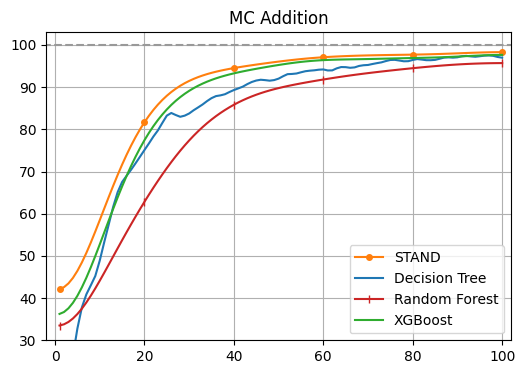

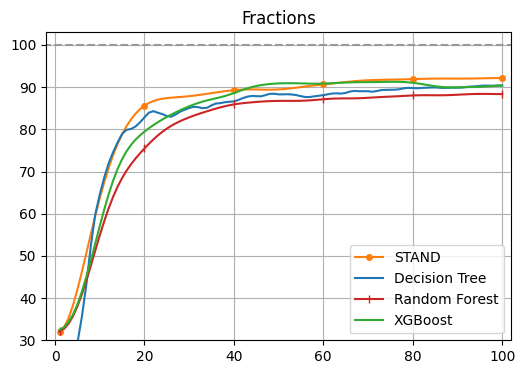

In [88]:
# Completeness
plot_stat(mc_conditions, "completeness", 0, "MC Addition", y_lim=(30,103), h_line=100, save_name="mc_compl")
plot_stat(frac_conditions, "completeness", 0, "Fractions", y_lim=(30,103), h_line=100, save_name="frac_compl")

/tmp/ipykernel_9239/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


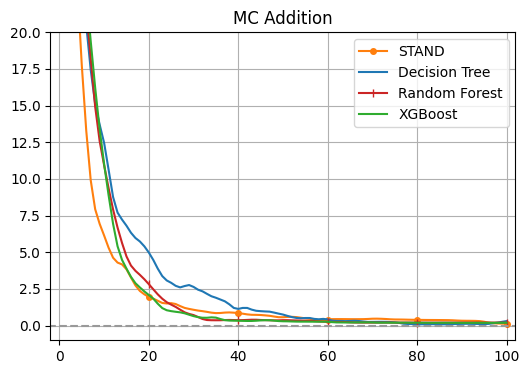

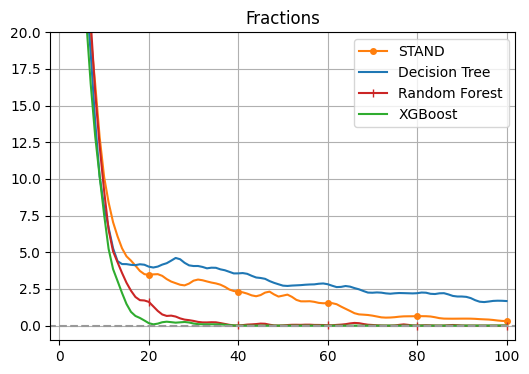

In [80]:
# Omission Rate
plot_stat(mc_conditions, "omission_rate", 0, "MC Addition", y_lim=(-1,20), h_line=0, save_name="mc_oms")
plot_stat(frac_conditions, "omission_rate", 0, "Fractions", y_lim=(-1,20), h_line=0, save_name="frac_oms")

/tmp/ipykernel_9239/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


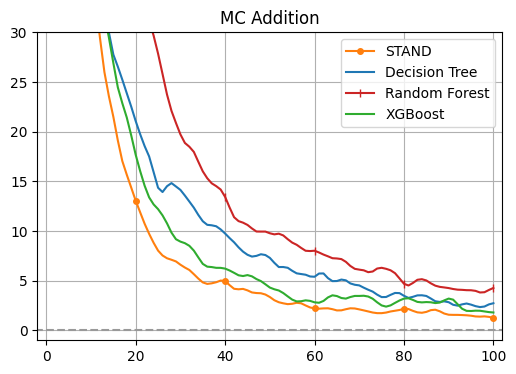

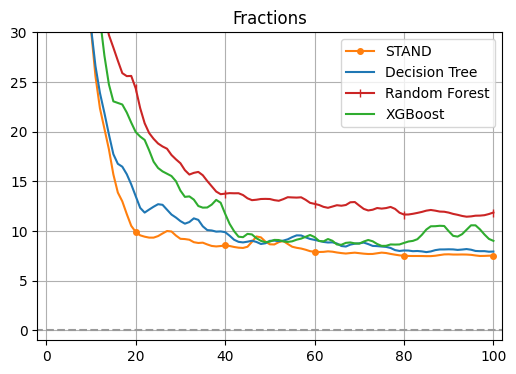

In [91]:
# Comission Rate
plot_stat(mc_conditions, "comission_rate", 0, "MC Addition", y_lim=(-1,30), h_line=0, save_name="mc_coms")
plot_stat(frac_conditions, "comission_rate", 0, "Fractions", y_lim=(-1,30), h_line=0, save_name="frac_coms")

/tmp/ipykernel_9239/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


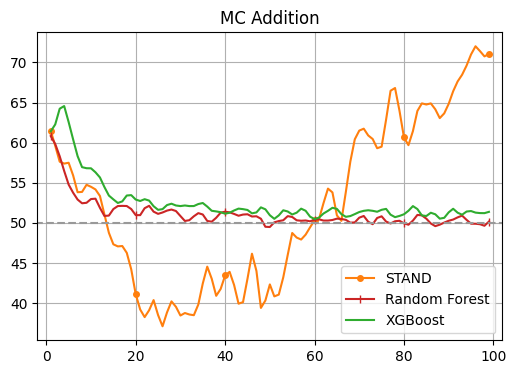

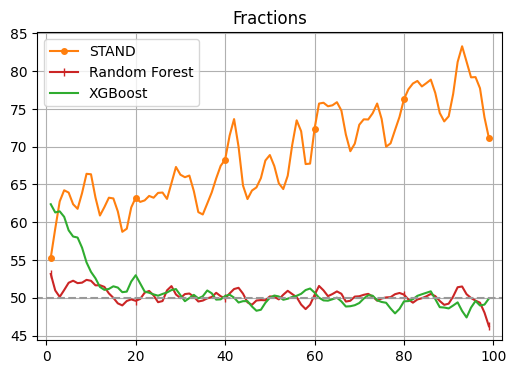

In [89]:
# Productive Monotonicity
plot_stat(mc_conditions, "prod_monot", 1, "MC Addition", skip=['decision_tree'], h_line=50, save_name="mc_prod_mont")
plot_stat(frac_conditions, "prod_monot", 1, "Fractions", skip=['decision_tree'], h_line=50, save_name="frac_prod_mont")

/tmp/ipykernel_9239/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


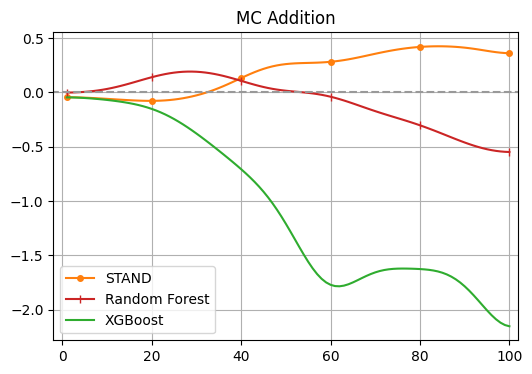

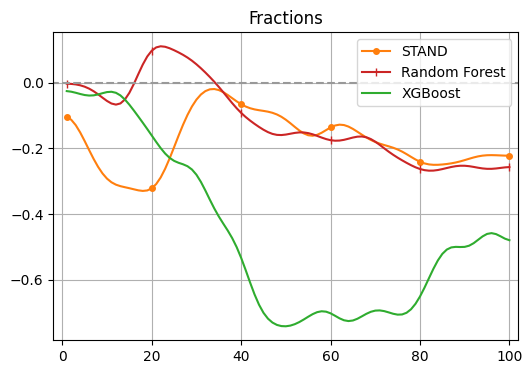

In [92]:
# Normalized Active Learning Utility
plot_diff(mc_conditions, mc_conditions_active, "completeness", 0, "MC Addition", h_line=0, save_name="mc_actl_util") 
plot_diff(frac_conditions, frac_conditions_active, "completeness", 0, "Fractions", h_line=0, save_name="frac_actl_util") 

/tmp/ipykernel_9239/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


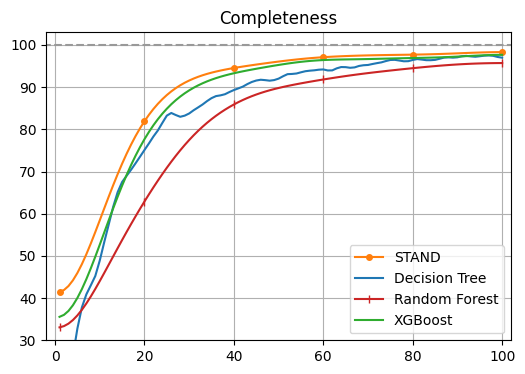

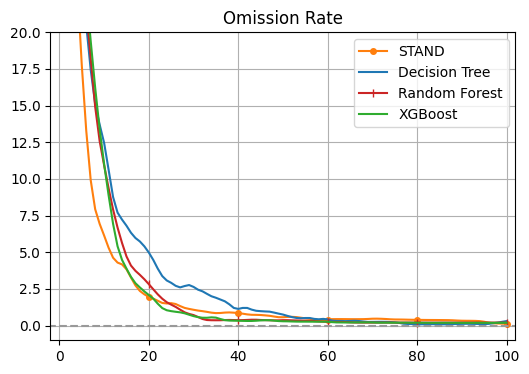

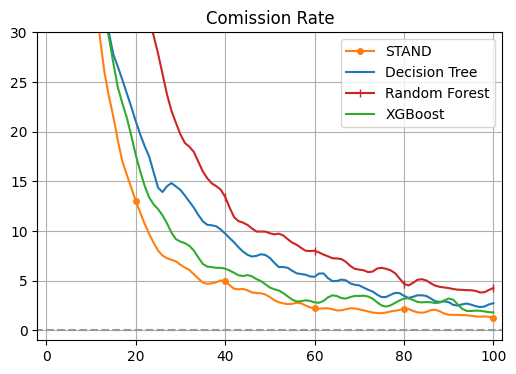

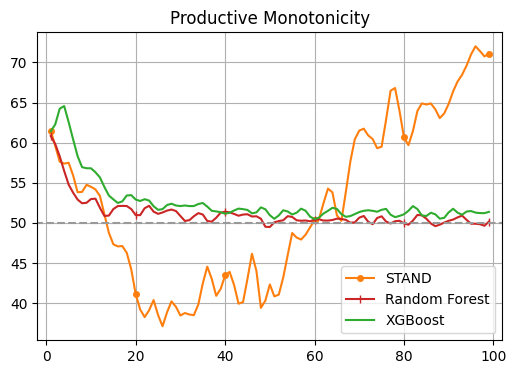

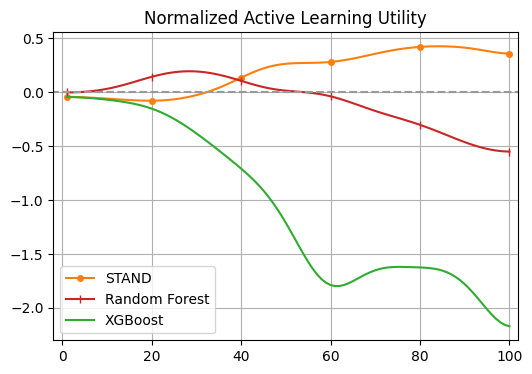

In [84]:
plot_stat(mc_conditions, "completeness", 0, "Completeness", y_lim=(30,103), h_line=100)
#plot_stat(mc_conditions, "step_score", 0, "Step Score")
plot_stat(mc_conditions, "omission_rate", 0, "Omission Rate", y_lim=(-1,20), h_line=0)
plot_stat(mc_conditions, "comission_rate", 0, "Comission Rate", y_lim=(-1,30), h_line=0)

plot_stat(mc_conditions, "prod_monot", 1, "Productive Monotonicity", skip=['decision_tree'], h_line=50)
#plot_stat(mc_conditions, "FP_reocc", 1, "Commission Reoccurance")
#plot_stat(mc_conditions, "FN_reocc", 1, "Ommission Reoccurance")
#plot_stat(mc_conditions, ('precision', .9), 1, "Precision @ 90%")
#plot_stat(mc_conditions, ('precision', 1.0), 1, "Precision @ 100%")

plot_diff(mc_conditions, mc_conditions_active, "completeness", 0, "Normalized Active Learning Utility", h_line=0) 



/tmp/ipykernel_9239/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


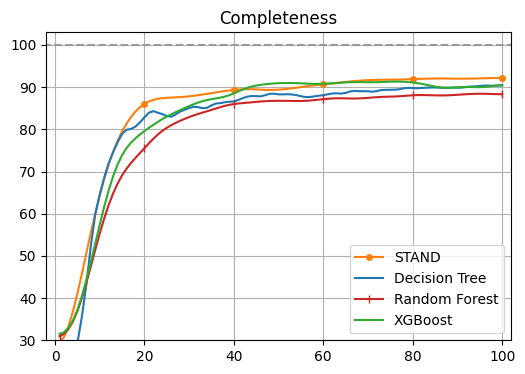

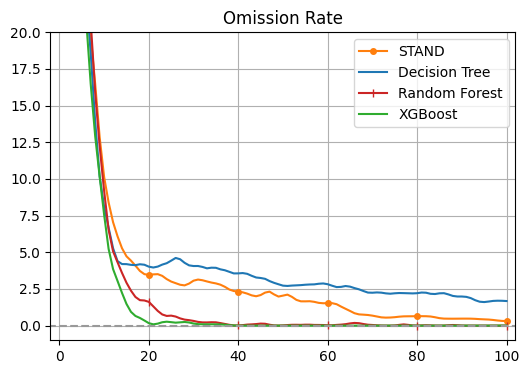

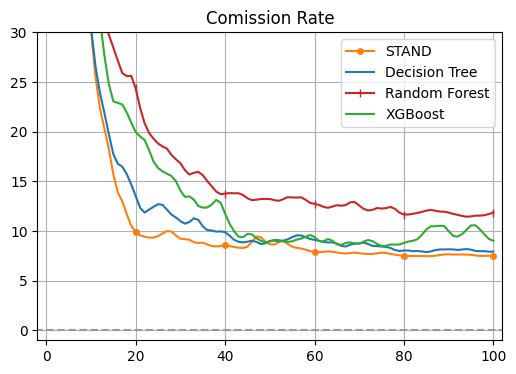

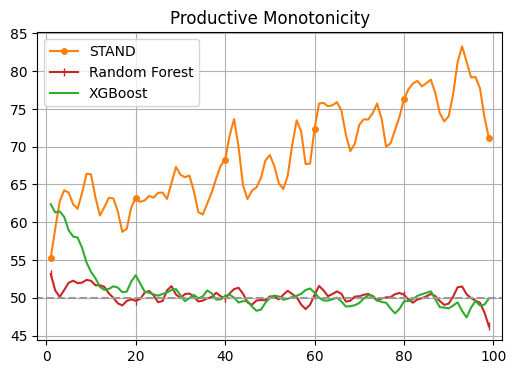

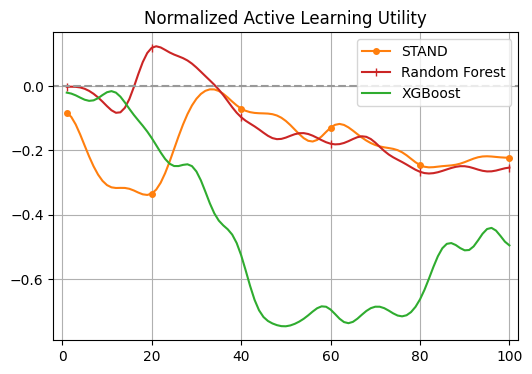

In [70]:
plot_stat(frac_conditions, "completeness", 0, "Completeness", y_lim=(30,103), h_line=100)
#plot_stat(frac_conditions, "step_score", 0, "Step Score")
plot_stat(frac_conditions, "omission_rate", 0, "Omission Rate", y_lim=(-1,20), h_line=0)
plot_stat(frac_conditions, "comission_rate", 0, "Comission Rate", y_lim=(-1,30), h_line=0)

plot_stat(frac_conditions, "prod_monot", 1, "Productive Monotonicity", skip=['decision_tree'], h_line=50)
#plot_stat(frac_conditions, "FP_reocc", 1, "Commission Reoccurance")
#plot_stat(frac_conditions, "FN_reocc", 1, "Ommission Reoccurance")
#plot_stat(frac_conditions, ('precision', .9), 1, "Precision @ 90%")
#lot_stat(frac_conditions, ('precision', 1.0), 1, "Precision @ 100%")
plot_diff(frac_conditions, frac_conditions_active, "completeness", 0, "Normalized Active Learning Utility", h_line=0) 

## Fit Time

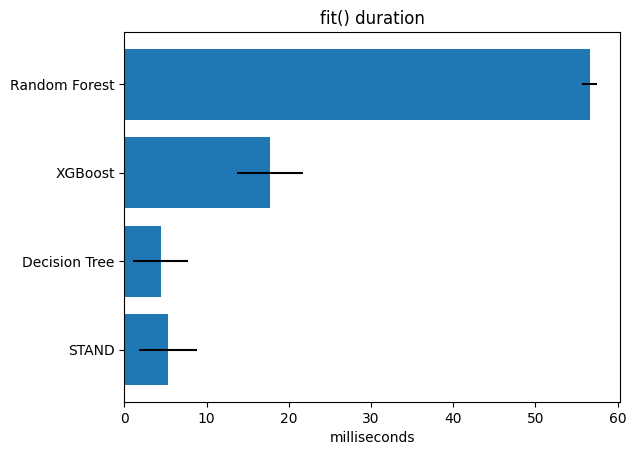

In [99]:
fit_times = {
    "stand" :         {"avg" : 5.3,   "std" : 3.539},
    "decision_tree" : {"avg" : 4.424, "std" : 3.327},
    "xg_boost" :      {"avg" : 17.735, "std" : 3.974},
    "random_forest" : {"avg" : 56.588, "std" : 0.876},
    
}

fig, ax = plt.subplots()

y_pos = np.arange(len(fit_times))
avgs = [v['avg'] for v in fit_times.values()]
stds = [v['std'] for v in fit_times.values()]

ax.barh(y_pos, avgs, xerr=stds, align='center', color=[cond_colors[k] for k in predict_times])
ax.set_yticks(y_pos, labels=[cond_labels[k] for k in fit_times])
#ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('milliseconds')
ax.set_title('fit() duration')
plt.savefig(f"plots/fit_times.png", bbox_inches='tight')
plt.savefig(f"plots/fit_times.eps", bbox_inches='tight', format='eps')
plt.savefig("fit_times.png"
plt.show()

## Predict Time

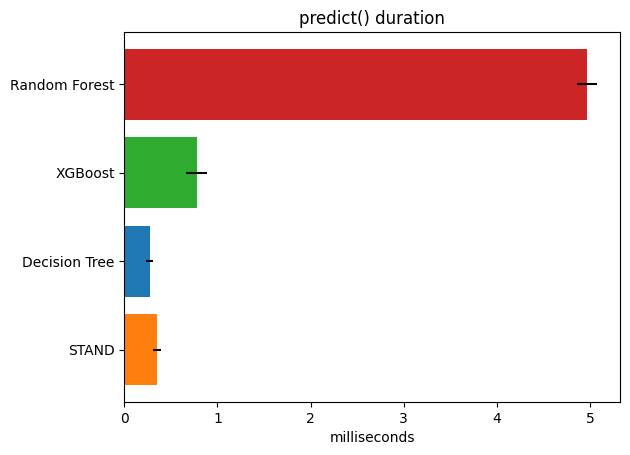

In [93]:
predict_times = {
    "stand" :         {"avg" : 0.355, "std" : 0.043},
    "decision_tree" : {"avg" : 0.273, "std" : 0.038},
    "xg_boost" :      {"avg" : 0.775, "std" : 0.112},
    "random_forest" : {"avg" : 4.969, "std" : 0.104},
    
}

fig, ax = plt.subplots()

y_pos = np.arange(len(predict_times))
avgs = [v['avg'] for v in predict_times.values()]
stds = [v['std'] for v in predict_times.values()]

ax.barh(y_pos, avgs, xerr=stds, align='center', color=[cond_colors[k] for k in predict_times])
ax.set_yticks(y_pos, labels=[cond_labels[k] for k in predict_times])
#ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('milliseconds')
ax.set_title('predict() duration')

plt.show()

In [82]:
def py_setitem(size):
    l = [0]*size
    for i in range(size):
        l[i] = i
    return l

def np_setitem(size):
    l = np.zeros(size)
    for i in range(size):
        l[i] = i
    return l

def py_getitem(size):
    l = [0]*size
    s = 0
    for i in range(size):
        s = l[i]
    return s
        
def np_getitem(size):
    l = np.zeros(size)
    s = 0
    for i in range(size):
        s = l[i]
    return s 
%timeit py_setitem(100000)
%timeit np_setitem(100000)
%timeit py_getitem(100000)
%timeit np_getitem(100000)

2.31 ms ± 95.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.05 ms ± 99.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.36 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.18 ms ± 57.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [112]:
from numba import njit, types, i8
from numba.typed import List
from numba.types import ListType

@njit(types.void(ListType(i8), i8))
def append_it(lst, other):
    lst.append(other)

append_it_ep = append_it.overloads[(ListType(i8), i8)].entry_point

def nb_append(size):
    l = List()
    for i in range(size):
        l.append(i)
    return l

def nb_append_custom(size):
    l = List.empty_list(i8)
    for i in range(size):
        append_it(l, i)
    return l

def nb_append_custom_ep(size):
    l = List.empty_list(i8)
    for i in range(size):
        append_it_ep(l, i)
    return l

def py_append(size):
    l = []
    for i in range(size):
        l.append(i)
    return l

%timeit py_append(100000)
%timeit nb_append(100000)
%timeit nb_append_custom(100000)
%timeit nb_append_custom_ep(100000)


4.1 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
111 ms ± 4.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
103 ms ± 8.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
40.9 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<function __main__._Closure.append_it>

In [29]:
from training import train_or_load_rep
for i in range(20):
    stats, _, _  = train_or_load_rep("mc", "stand", False, False, 100, i)
    print(i, stats['completeness'][-1])

for i in range(20):
    stats, _, _  = train_or_load_rep("mc", "stand", False, True, 100, i)
    print(i, stats['completeness'][-1])


SKIP REP:  0
0 1.0
SKIP REP:  1
1 1.0
SKIP REP:  2
2 0.9718875502008032
SKIP REP:  3
3 0.9585006693440429
SKIP REP:  4
4 0.9973226238286479
SKIP REP:  5
5 1.0
SKIP REP:  6
6 1.0
SKIP REP:  7
7 0.9491298527443106
SKIP REP:  8
8 0.9477911646586346
SKIP REP:  9
9 0.9866131191432396
SKIP REP:  10
10 1.0
SKIP REP:  11
11 0.9973226238286479
SKIP REP:  12
12 0.9919678714859438
SKIP REP:  13
13 1.0
SKIP REP:  14
14 0.9919678714859438
SKIP REP:  15
15 0.9852744310575636
SKIP REP:  16
16 0.9692101740294511
SKIP REP:  17
17 1.0
SKIP REP:  18
18 0.9585006693440429
SKIP REP:  19
19 1.0
SKIP REP:  0
0 1.0
SKIP REP:  1
1 1.0
SKIP REP:  2
2 1.0
SKIP REP:  3
3 0.9759036144578314
SKIP REP:  4
4 1.0
SKIP REP:  5
5 0.9892904953145917
SKIP REP:  6
6 0.9156626506024096
SKIP REP:  7
7 1.0
SKIP REP:  8
8 0.9892904953145917
SKIP REP:  9
9 0.9759036144578314
SKIP REP:  10
10 0.927710843373494
SKIP REP:  11
11 0.9946452476572959
SKIP REP:  12
12 0.9919678714859438
SKIP REP:  13
13 0.9919678714859438
SKIP REP:  1

In [19]:
# from training import load_rep
import numpy as np
n_100 = 0
for i in range(40):
    tup = load_rep("frac", "xg_boost", False, False, 100, i)
    if(tup is not None):
        stats, _, _ = tup
        compl = stats['completeness']
        print(i, np.max(compl[10:30]), np.argmax(compl[10:30])+10, compl[-1])
        if(compl[-1] == 1.0):
            n_100 += 1
    else:
        print(i, None)

print(f"{n_100}/{40}")

0 0.9288793103448276 27 0.8943965517241379
1 0.9288793103448276 23 0.9234913793103449
2 0.8577586206896551 15 0.9288793103448276
3 0.9288793103448276 24 0.9202586206896551
4 0.9288793103448276 29 0.9288793103448276
5 0.9267241379310345 15 0.8933189655172413
6 0.9288793103448276 14 0.9288793103448276
7 0.8933189655172413 22 0.9202586206896551
8 0.9288793103448276 19 0.9288793103448276
9 0.9288793103448276 28 0.9288793103448276
10 0.8577586206896551 10 0.9288793103448276
11 0.8265086206896551 24 0.9288793103448276
12 0.9267241379310345 21 0.9288793103448276
13 0.9288793103448276 22 0.8933189655172413
14 0.9288793103448276 29 0.9288793103448276
15 0.9288793103448276 20 0.8685344827586207
16 0.9288793103448276 14 0.8868534482758621
17 0.8890086206896551 13 0.9288793103448276
18 0.8243534482758621 23 0.9288793103448276
19 0.9288793103448276 15 0.9267241379310345
20 0.9288793103448276 21 0.9202586206896551
21 0.9234913793103449 24 0.9288793103448276
22 0.8933189655172413 25 0.920258620689655